# Analyse de sensibilité globale avec les indices de Sobol' - application au cas de la déviation verticale de la poutre


# Model definition

In [1]:
import openturns as ot
import numpy as np
import openturns.viewer as otv
import tabulate

In [2]:
class Plongeoir:
    """
    Définit le modèle physique et probabiliste d'un plongeoir.

    Cette classe encapsule la définition des variables aléatoires d'entrée
    (module de Young, charge, longueur, moment d'inertie) et la fonction
    modèle calculant la déviation verticale de la poutre.

    Examples
    --------
    >>> plongeoir = Plongeoir()
    >>> X = plongeoir.getProbabilisticModel()
    >>> g = plongeoir.getPhysicalModel()
    """
    def __init__(self):
        """
        Initialise les distributions et le modèle symbolique.
        """
        distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
        distributionE.setDescription(["E"])
        parametersF = ot.LogNormalMuSigma(
            300.0, 30.0, 0.0
        )  # Paramétrage par les moments
        distributionF = ot.ParametrizedDistribution(parametersF)
        distributionF.setDescription(["F"])
        distributionL = ot.Uniform(2.50, 2.60)  # En mètres
        distributionL.setDescription(["L"])
        distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
        distributionI.setDescription(["I"])

        self.distribution = ot.JointDistribution(
            [distributionE, distributionF, distributionL, distributionI]
        )

        self.model = ot.SymbolicFunction(
            ["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"]
        )
        self.model.setOutputDescription(["Y (m)"])

    def getProbabilisticModel(self):
        """
        Retourne la distribution conjointe des variables d'entrée.

        Returns
        -------
        distribution : ot.JointDistribution
            La distribution conjointe des variables aléatoires d'entrée.
        """
        return self.distribution

    def getPhysicalModel(self):
        """
        Retourne le modèle physique sous forme de fonction symbolique.

        Returns
        -------
        model : ot.SymbolicFunction
            La fonction calculant la déviation verticale.
        """
        return self.model

In [3]:
ot.Log.Show(ot.Log.NONE)

ot.RandomGenerator.SetSeed(0)

plongeoir = Plongeoir()
X = plongeoir.getProbabilisticModel()
g = plongeoir.getPhysicalModel()

Enfin, nous définissons le vecteur aléatoire de sortie.

In [4]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (m)"])

## Estimer les indices de Sobol' avec un budget fixé

In [5]:
sampleSize = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(X, sampleSize, computeSecondOrder)
inputDesign = sie.generate()

In [6]:
inputDesign.getSize()

3000

In [7]:
outputDesign = g(inputDesign)

La librairie dispose de quatre estimateurs des indices de Sobol'. Ici, nous proposons d'utiliser l'estimateur de Saltelli. 

In [8]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, sampleSize)

On souhaite obtenir la distribution asymptotique.

In [9]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

Les méthodes `getFirstOrderIndices` et `getTotalOrderIndices` permettent de récupérer les indices du premier ordre et totaux.

In [10]:
firstOrderMonteCarlo = sensitivityAnalysis.getFirstOrderIndices()
firstOrderMonteCarlo

class=Point name=Unnamed dimension=4 values=[0.0163206,0.684515,0.0431776,0.131372]

In [11]:
totalOrderMonteCarlo = sensitivityAnalysis.getTotalOrderIndices()
totalOrderMonteCarlo

class=Point name=Unnamed dimension=4 values=[0.0657028,0.726716,0.0812739,0.161218]

La méthode `draw` propose une méthode de dessin des indices de Sobol' qui permet d'observer à la fois les indices du premier ordre, les indices totaux et les intervalles de confiance.

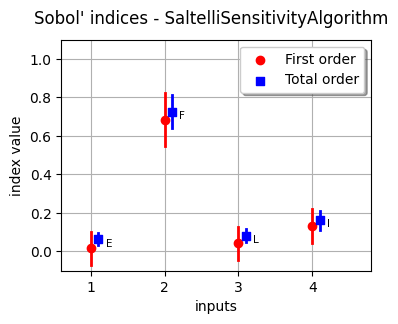

In [12]:
graph = sensitivityAnalysis.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La méthode `DrawSobolIndices` permet de réaliser un graphique similaire lorsque les indices sont déjà disponibles.

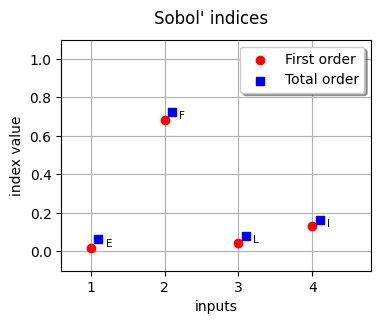

In [13]:
inputDescription = X.getDescription()
graph = ot.SaltelliSensitivityAlgorithm.DrawSobolIndices(
    inputDescription, firstOrderMonteCarlo, totalOrderMonteCarlo
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [14]:
firstOrderDistribution = sensitivityAnalysis.getFirstOrderIndicesDistribution()
firstOrderDistribution

class=Normal name=Normal dimension=4 mean=class=Point name=Unnamed dimension=4 values=[0.0163206,0.684515,0.0431776,0.131372] sigma=class=Point name=Unnamed dimension=4 values=[0.0445144,0.0699642,0.04396,0.0444308] correlationMatrix=class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]

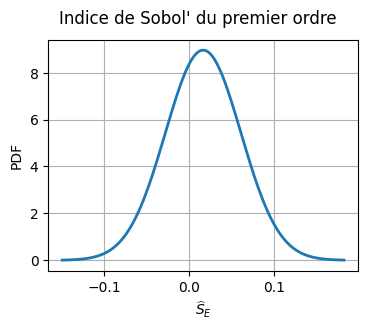

In [15]:
firstOrderMarginalDistribution = firstOrderDistribution.getMarginal(0)
graph = firstOrderMarginalDistribution.drawPDF()
graph.setXTitle(r"$\widehat{S}_E$")
graph.setTitle("Indice de Sobol' du premier ordre")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Estimer les indices de Sobol' avec un algorithme incrémental


In [16]:
alpha = 0.05  # i.e. 95% confidence interval
epsilon = 0.2  # Confidence interval length
blockSize = 200  # Number of points evaluated simultaneously
designSize = 64  # Size of Sobol experiment at each iteration
maximumOuterSampling = 1200  # Number of outer iterations of the algorithm

estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(X, g, estimator)
algo.setMaximumOuterSampling(maximumOuterSampling)
algo.setBlockSize(blockSize)
algo.setExperimentSize(designSize)
algo.setIndexQuantileLevel(alpha)
algo.setIndexQuantileEpsilon(epsilon)
algo.run()

result = algo.getResult()
firstOrderIterative = result.getFirstOrderIndicesEstimate()
totalOrderIterative = result.getTotalOrderIndicesEstimate()
print(f"First order = {firstOrderIterative}")
print(f"Total order = {totalOrderIterative}")

First order = [0.055354,0.733065,0.0863531,0.168355]
Total order = [0.0445875,0.700241,0.0938737,0.173634]


In [17]:
outerSampling = result.getOuterSampling()
print("outerSampling = ", outerSampling)
if outerSampling == maximumOuterSampling:
    print("Attention : le nombre maximum d'itérations externes est atteint!")

numberOfFunctionEvaluations = outerSampling * blockSize
print(f"Number of function evaluation = {numberOfFunctionEvaluations}")

outerSampling =  38
Number of function evaluation = 7600


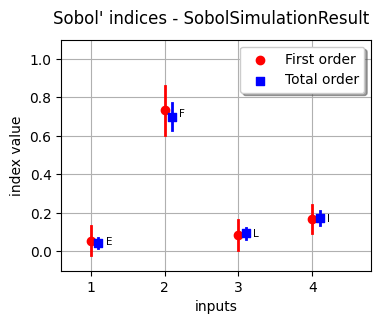

In [18]:
graph = result.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

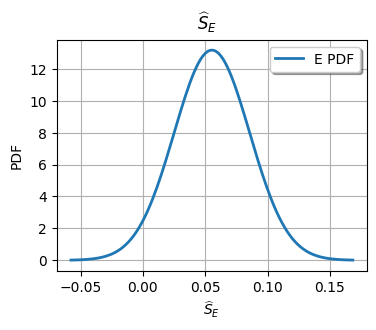

In [19]:
distributionFirstOrder = result.getFirstOrderIndicesDistribution()
distributionFirstOrderMarginal = distributionFirstOrder.getMarginal(0)
graph = distributionFirstOrderMarginal.drawPDF()
graph.setTitle(r"$\widehat{S}_E$")
graph.setXTitle(r"$\widehat{S}_E$")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Solution de l'exercice 1 : fonction produit

In [20]:
g = ot.SymbolicFunction(["X1", "X2"], ["X1 * X2"])
X1 = ot.Normal(0.0, 10.0)
X2 = ot.Uniform(-1.0, 1.0)
X = ot.JointDistribution([X1, X2])
inputDescription = ["X1", "X2"]
X.setDescription(inputDescription)

In [21]:
n = 10000
sampleX = X.getSample(n)
sampleY = g(sampleX)


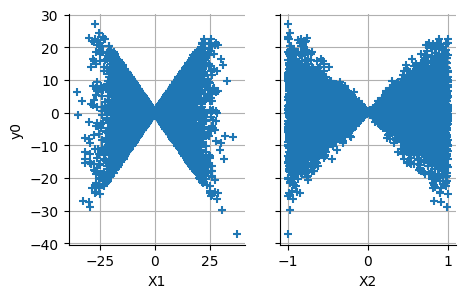

In [22]:
graph = ot.VisualTest.DrawPairsXY(sampleX, sampleY)
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

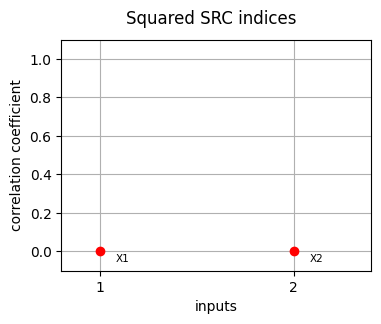

In [23]:
correlationAnalysis = ot.CorrelationAnalysis(sampleX, sampleY)
squaredSRCindices = correlationAnalysis.computeSquaredSRC()
inputNames = g.getInputDescription()
title = "Squared SRC indices"
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    squaredSRCindices, inputNames, title
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les indices SRC carrés sont nuls.

Pour valider notre résultat, nous utilisons la méthode `CorrelationAnalysis.computeLinearCorrelation()` qui calcule le coefficient de corrélation linéaire. 

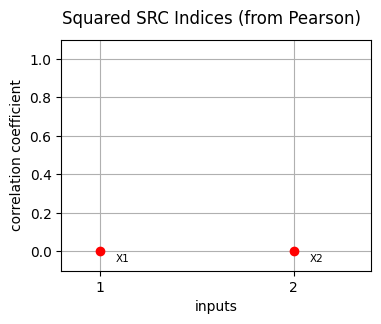

In [24]:
pearsonCorrelation = correlationAnalysis.computeLinearCorrelation()
squaredSRCindices = ot.Point(2)
squaredSRCindices[0] = pearsonCorrelation[0] ** 2
squaredSRCindices[1] = pearsonCorrelation[1] ** 2
title = "Squared SRC Indices (from Pearson)"
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    squaredSRCindices, inputNames, title
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les résultats sont identiques. Il s'avère que ce modèle est associé à une somme des coefficients SRC carrés qui est égale à 0. Cela implique que la variance de la sortie n'est pas expliquée par le modèle linéaire, qui est donc ici une très mauvaise approximation de la fonction $g$. Les indices SRC carrés ne peuvent donc pas être utilisés dans ce cas.

Pour obtenir des résultats valables, on utilise alors les indices de Sobol'.

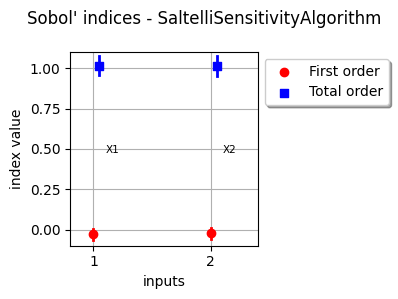

In [25]:
sampleSize = 10000
sie = ot.SobolIndicesExperiment(X, sampleSize)
inputDesign = sie.generate()
outputDesign = g(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, sampleSize)
graph = sensitivityAnalysis.draw()
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les indices du premier ordre sont tous les deux proches de 0 et que les indices totaux sont tous les deux proches de 1. Pour valider ce résultat, nous réalisons un calcul théorique.

**Analyse théorique.**

Pour $i=1,2$, notons $\mu_i = \mathbb{E}[X_i]$ l'espérance et $\sigma_i^2 = \operatorname{Var}(X_i)$ la variance. Notons $f_i$ la densité de probabilité de la variable $X_i$ pour $i=1,2$ et $f_{1,2}$ la densité de probabilité 
du vecteur aléatoire $(X_1,X_2)$. Puisque les variable $X_1$ et $X_2$ sont indépendantes, la densité de probabilité du vecteur aléatoire $(X_1,X_2)$ est le produit des lois marginales :

$$
f_{1,2}(x_1,x_2) = f_1(x_1)f_2(x_2)
$$

pour tout $x_1,x_2\in\mathbb{R}$.

On en déduit que l'espérance de $Y$ est égale au produit des espérances de $X_1$ et $X_2$. 
En effet, 

\begin{align*}
\mathbb{E}[Y] 
&= \mathbb{E}[X_1 X_2] \\
&= \int_{\mathbb{R}^2} x_1 x_2 f_{1,2}(x_1,x_2) dx_1 dx_2 \\
&= \int_{\mathbb{R}^2} x_1 x_2 f_1(x_1)f_2(x_2) dx_1 dx_2 \\
&= \left(\int_{\mathbb{R}} x_1 f_1(x_1) dx_1\right) \left(\int_{\mathbb{R}} f_2(x_2) dx_2 \right) \\
&= \mathbb{E}[X_1] \mathbb{E}[X_2] \\
&= \mu_1 \mu_2
\end{align*}

La variance de $Y$ est :

\begin{align*}
\operatorname{Var}(Y) 
&= \mathbb{E}\left[Y^2\right] - \mathbb{E}[Y]^2 \\
&= \mathbb{E}\left[(X_1 X_2)^2\right] - \mathbb{E}[Y]^2 \\
&= \mathbb{E}\left[X_1^2\right] \mathbb{E}\left[X_2^2\right] - \mathbb{E}[Y]^2 \quad \textrm{ (par indépendance)}.
\end{align*}

Or, pour $i=1,2$, on a :

$$
\mathbb{E}[X_i^2] = \operatorname{Var}(X_i) + \mathbb{E}[X_i]^2 = \sigma_i^2 + \mu_i^2.
$$

Par conséquent, 

\begin{align*}
\operatorname{Var}(Y) 
&= \left(\sigma_1^2 + \mu_1^2\right) \left(\sigma_2^2 + \mu_2^2\right) - \mu_1^2 \mu_2^2 \\
&= \sigma_1^2 \sigma_2^2 + \sigma_1^2 \mu_2^2 + \sigma_2^2 \mu_1^2.
\end{align*}

L'indice de Sobol' du premier ordre de $X_1$ est :

\begin{align*}
S_1
&= \frac{\operatorname{Var}(\mathbb{E}(Y|X_1))}{\operatorname{Var}(Y)} \\
&= \frac{\operatorname{Var}(X_1 \mathbb{E}[X_2])}{\operatorname{Var}(Y)} \\
&= \frac{\operatorname{Var}(X_1 \mu_2)}{\operatorname{Var}(Y)} \\
&= \frac{\mu_2^2 \operatorname{Var}(X_1)}{\operatorname{Var}(Y)} \\
&= \frac{\mu_2^2 \sigma_1^2}{\operatorname{Var}(Y)}.
\end{align*}

De même, 

\begin{align*}
S_2
&= \frac{\mu_1^2 \sigma_2^2}{\operatorname{Var}(Y)}.
\end{align*}

Étant donnée la variance totale $\operatorname{Var}(Y)$, l'indice du second ordre $S_{1,2}$ est égal à 

\begin{align*}
S_{1,2} 
&= 1 - S_1 - S_2 \\
&= \frac{\operatorname{Var}(Y) - S_1 \operatorname{Var}(Y) - S_2 V(Y)}{\operatorname{Var}(Y)} \\
&= \frac{\sigma_1^2 \sigma_2^2 + \sigma_1^2 \mu_2^2 + \sigma_2^2 \mu_1^2 - \mu_2^2 \sigma_1^2 - \mu_1^2 \sigma_2^2}{V(Y)} \\
&= \frac{\sigma_1^2 \sigma_2^2}{\operatorname{Var}(Y)}.
\end{align*}



Le numérateur de l'indice SRC carré de $X_1$ est égal à la corrélation entre $Y$ et $X_1$. 
Par définition, la covariance est égale à :

\begin{align*}
\operatorname{Cov}(Y,X_1)
&= \mathbb{E}[(Y - \mathbb{E}[Y])(X_1 - \mathbb{E}[X_1])] \\
&= \mathbb{E}[Y X_1] - \mathbb{E}[Y] \mathbb{E}[X_1] \\
&= \mathbb{E}[X_1^2 X_2] - \mu_1 \mu_2 \mu_1 \\
&= \mathbb{E}[X_1^2] \mathbb{E}[X_2] - \mu_1^2 \mu_2 \quad \textrm{ (par indépendance)} \\
&= (\sigma_1^2 + \mu_1^2) \mu_2 - \mu_1^2 \mu_2 \\
&= \sigma_1^2 \mu_2.
\end{align*}

De même, 

\begin{align*}
\operatorname{Cov}(Y,X_2)
&= \mathbb{E}[(Y-\mathbb{E}[Y])(X_2 - \mathbb{E}[X_2])] \\
&= \mathbb{E}[Y X_2] - \mathbb{E}[Y] \mathbb{E}[X_2] \\
&= \mathbb{E}[X_1 X_2^2] - \mu_1 \mu_2 \mu_2 \\
&= \mathbb{E}[X_1] \mathbb{E}[X_2^2] - \mu_1 \mu_2^2 \quad \textrm{ (par indépendance)} \\
&= \mu_1 (\sigma_2^2 + \mu_2^2) - \mu_1 \mu_2^2 \\
&= \mu_1 \sigma_2^2 .
\end{align*}

Par conséquent,

\begin{align*}
\operatorname{SRC}_1
&= \operatorname{Corr}(Y,X_1) \\
&= \frac{\operatorname{Cov}(Y,X_1)}{\sqrt{\operatorname{Var}(Y)}\sqrt{\operatorname{Var}(X_1)}} \\
&= \frac{\sigma_1^2 \mu_2}{\sqrt{\operatorname{Var}(Y)}\sigma_1} \\
&= \frac{\sigma_1 \mu_2}{\sqrt{\operatorname{Var}(Y)}}
\end{align*}

et :

\begin{align*}
\operatorname{SRC}_2
&= \operatorname{Corr}(Y,X_2) \\
&= \frac{\operatorname{Cov}(Y,X_2)}{\sqrt{\operatorname{Var}(Y)}\sqrt{\operatorname{Var}(X_2)}} \\
&= \frac{\mu_1 \sigma_2^2}{\sqrt{\operatorname{Var}(Y)}\sigma_2} \\
&= \frac{\mu_1 \sigma_2}{\sqrt{\operatorname{Var}(Y)}}.
\end{align*}

Les équations précédentes mènent au code suivant.

In [26]:
mu1 = X1.getMean()[0]
mu2 = X2.getMean()[0]
sigma1 = X1.getStandardDeviation()[0]
sigma2 = X2.getStandardDeviation()[0]
EY = mu1 * mu2
VY = sigma1**2 * sigma2**2 + sigma1**2 * mu2**2 + sigma2**2 * mu1**2
S1 = sigma1**2 * mu2**2 / VY
S2 = mu1**2 * sigma2**2 / VY
S12 = sigma1**2 * sigma2**2 / VY
T1 = S1 + S12
T2 = S2 + S12
SRC1 = sigma1 * mu2 / np.sqrt(VY)
SRC2 = mu1 * sigma2 / np.sqrt(VY)
print(f"E[Y]={EY}")
print(f"Var(Y)={VY}")
print(f"S1={S1}, T1 = {T1}, SRC1 = {SRC1}")
print(f"S2={S2}, T2 = {T2}, SRC2 = {SRC2}")

E[Y]=0.0
Var(Y)=33.33333333333334
S1=0.0, T1 = 1.0, SRC1 = 0.0
S2=0.0, T2 = 1.0, SRC2 = 0.0


On observe que les indices SRC sont égaux à zéro. On observe également que les indices du premier ordre sont égaux à zéro tandis que les indices totaux sont égaux à 1. Cela implique que la variabilité de la sortie est due exclusivement à l'interaction entre X1 et X2. C'est une conclusion cohérente avec la structure de la fonction produit. 

## Exercice 2 : fonction Ishigami

In [27]:
inputNames = ["X1", "X2", "X3"]
g = ot.SymbolicFunction(inputNames, ["sin(X1) + 7 * sin(X2)^2 + 0.1 * X3^4 * sin(X1)"])
X = ot.JointDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
X.setDescription(inputNames)

## Solution de l'exercice 2 : fonction Ishigami

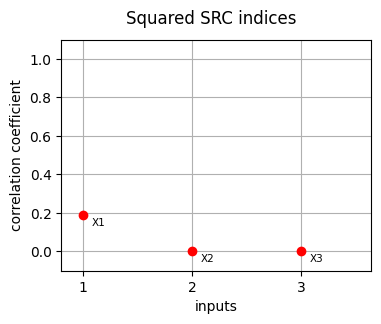

In [28]:
n = 10000
sampleX = X.getSample(n)
sampleY = g(sampleX)
correlationAnalysis = ot.CorrelationAnalysis(sampleX, sampleY)
squaredSRCindices = correlationAnalysis.computeSquaredSRC()
inputNames = g.getInputDescription()
title = "Squared SRC indices"
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    squaredSRCindices, inputNames, title
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

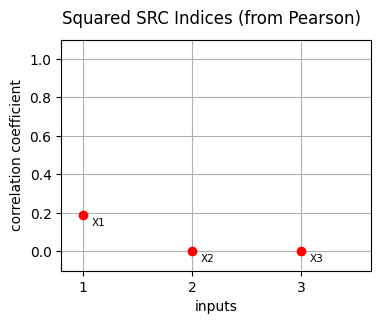

In [29]:
squaredSRCindices = ot.Point(3)
pearsonCorrelation = correlationAnalysis.computeLinearCorrelation()
squaredSRCindices[0] = pearsonCorrelation[0] ** 2
squaredSRCindices[1] = pearsonCorrelation[1] ** 2
squaredSRCindices[2] = pearsonCorrelation[2] ** 2
title = "Squared SRC Indices (from Pearson)"
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    squaredSRCindices, inputNames, title
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

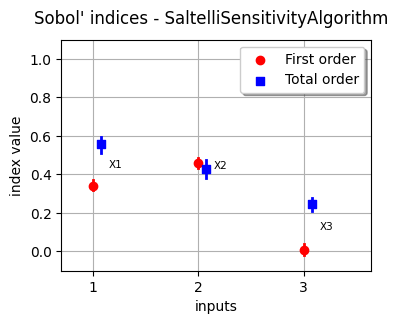

In [30]:
sampleSize = 10000
sie = ot.SobolIndicesExperiment(X, sampleSize)
inputDesign = sie.generate()
outputDesign = g(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, sampleSize)
graph = sensitivityAnalysis.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

**Analyse.**

- On observe que la variable $X_1$, avec un indice de Sobol' total proche de 0.6, est la variable qui possède le plus d'impact par elle même ou par ses interactions. En effet, son indice du premier ordre est proche de 0.3, ce qui implique que les interactions entre $X_1$ et les autres variables comptent pour approximativement 30% de la variance totale. 
- La variable $X_2$ possède un indice du premier ordre proche de l'indice total, ce qui implique qu'elle n'interagit pas avec les autres variables. Son indice total est approximativement égal à 0.4. 
- La variable $X_3$ possède un indice du premier ordre proche de zéro. Elle a un impact sur la variabilité de la sortie uniquement via ses interactions avec les autres variables. 

## Solution de l'exercice 3 : variabilité de l'estimateur


Pour éviter que l'exécution d'autres cellules du Notebook ne modifie le modèle probabiliste ou le modèle physique, nous les définissons ci-dessous.

In [31]:
plongeoir = Plongeoir()
X = plongeoir.getProbabilisticModel()
g = plongeoir.getPhysicalModel()
#
r = 100
sampleS = ot.Sample(r, 4)
n = 500
for j in range(r):
    sie = ot.SobolIndicesExperiment(X, n, True)
    inputDesign = sie.generate()
    outputDesign = g(inputDesign)
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, n)
    sampleS[j, :] = sensitivityAnalysis.getFirstOrderIndices()

Pour dessiner la distribution asymptotique, nous créons la variable `mu` contenant la moyenne empirique de la i-ème colonne de `sampleS`. En effet, si l'on trace la distribution asymptotique sans modification de la moyenne, alors la gaussienne est centrée sur l'estimation associée à une seule expérience, et non pas sur le centre de l'histogramme. Cette situation est tout à fait normale. Toutefois, nous cherchons surtout à comparer la variance asymptotique et la variance empirique. C'est pour cette raison que, pour pouvoir comparer les deux distributions, nous décalons le centre de la gaussienne pour le mettre au centre de l'histogramme.

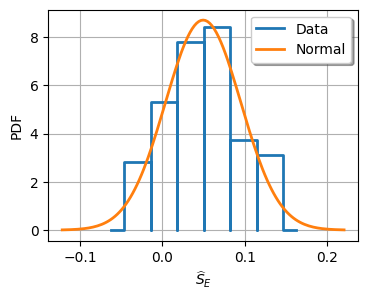

In [32]:
inputDescription = X.getDescription()
i = 0
histogram = ot.HistogramFactory().build(sampleS[:, i]).drawPDF()
histogram.setLegends(["Data"])
histogram.setTitle("")
S = sensitivityAnalysis.getFirstOrderIndicesDistribution()
S1 = S.getMarginal(i)
mu = sampleS.computeMean()[i]
sigma = S1.getStandardDeviation()[i]
S1_shifted = ot.Normal(mu, sigma)
graphPDF = S1_shifted.drawPDF()
graphPDF.setLegends(["Normal"])
histogram.setXTitle(fr"$\widehat{{S}}_{{{inputDescription[i]}}}$")
histogram.add(graphPDF)
view = otv.View(histogram, figure_kw={"figsize": (4.0, 3.0)})

## Exercice 4 : estimation par échantillonnage

In [33]:
def sampleDotProduct(sampleA, sampleB):
    """
    Computes the dot product of two 1D-samples.

    Parameters
    ----------
    sampleA : ot.Sample(sampleSize, 1)
        A sample.
    sampleB : ot.Sample(sampleSize, 1)
        A sample.

    Returns
    -------
    y : float
        The dot product of sampleA and sampleB.

    """
    sampleAPoint = sampleA.asPoint()
    sampleBPoint = sampleB.asPoint()
    y = sampleAPoint.dot(sampleBPoint)
    return y


## Solution de l'exercice 4 : estimation avec un algorithme

Pour éviter que l'exécution d'autres cellules du Notebook ne modifie le modèle probabiliste ou le modèle physique, nous les définissons ci-dessous.

In [34]:
plongeoir = Plongeoir()
X = plongeoir.getProbabilisticModel()
g = plongeoir.getPhysicalModel()

In [35]:
# Génère un premier plan d'expériences de taille `n`.
sampleSize = 500
XA = X.getSample(sampleSize)
YA = g(XA)
# Génère un second plan.
XB = X.getSample(sampleSize)
YB = g(XB)
# Centre les échantillons de sortie. 
center = 0.5 * (YA.computeMean()[0] + YB.computeMean()[0])
YA -= center
YB -= center

Estime les indices du premier ordre et totaux.

In [36]:
dimension = X.getDimension()
firstOrderSaltelli = ot.Point(dimension)  # Indice du premier ordre
totalOrderSaltelli = ot.Point(dimension)  # Indice total
norm2_yA = sampleDotProduct(YA, YA)
norm2_yB = sampleDotProduct(YB, YB)
for i in range(dimension):
    XEi = ot.Sample(XA)  # Crée une copie
    XEi[:, i] = XB[:, i]  # Substitue la i-ème colonne
    YEi = g(XEi) - center
    firstOrderSaltelli[i] = sampleDotProduct(YB, YEi) / norm2_yB
    totalOrderSaltelli[i] = 1.0 - sampleDotProduct(YA, YEi) / norm2_yA

print(f"(Saltelli) First order = {firstOrderSaltelli}")
print(f"(Saltelli) Total order = {totalOrderSaltelli}")

(Saltelli) First order = [0.0501743,0.651778,0.0614789,0.206378]
(Saltelli) Total order = [0.0637237,0.763272,0.0608697,0.132619]


La cellule suivante utilise la méthode de Martinez pour l'estimation des indices de sensibilité. On observe que la méthode de Martinez centre les sorties de la fonction $g$, grâce à l'utilisation du coefficient de corrélation de Pearson. Il n'est pas nécessaire de centrer les échantillons, car le coefficient de Pearson est centré par définition.

In [37]:
sampleSize = 500
dimension = X.getDimension()
XA = X.getSample(sampleSize)
XB = X.getSample(sampleSize)
YA = g(XA)
YB = g(XB)
firstOrderMartinez = ot.Point(dimension)
totalOrderMartinez = ot.Point(dimension)
for i in range(dimension):
    XEi = ot.Sample(XA)  # Crée une copie
    XEi[:, i] = XB[:, i]
    YEi = g(XEi)
    firstOrderMartinez[i] = ot.CorrelationAnalysis(YB, YEi).computeLinearCorrelation()[0]
    totalOrderMartinez[i] = 1.0 - ot.CorrelationAnalysis(YA, YEi).computeLinearCorrelation()[0]
print(f"(Martinez) First order = {firstOrderMartinez}")
print(f"(Martinez) Total order = {totalOrderMartinez}")

(Martinez) First order = [0.0558231,0.723353,0.0764,0.165129]
(Martinez) Total order = [0.0493075,0.712171,0.0867115,0.160954]


Comparons les estimations obtenues avec les méthodes suivantes :
- Monte-Carlo : la classe `SobolIndicesExperiment` avec la classe `SaltelliSensitivityAlgorithm` ($n$ fixé par l'utilisateur),
- Iterative : la classe `SobolSimulationAlgorithm` avec la classe `SaltelliSensitivityAlgorithm` (précision fixée par l'utilisateur),
- l'estimateur de Saltelli ($n$ fixé par l'utilisateur),
- l'estimateur de Martinez ($n$ fixé par l'utilisateur).

In [38]:
# Définition des en-têtes avec le titre de la première colonne suivi des descriptions
en_tetes = ["Indice de Sobol", "Monte-Carlo", "Iterative", "Saltelli", "Martinez"]

# Création des lignes du tableau en concaténant le nom de la méthode avec sa liste de valeurs
donnees_tableau = []
for i in range(dimension):
    donnees_tableau.append(
        [
            f"S_{inputDescription[i]}",
            firstOrderMonteCarlo[i],
            firstOrderIterative[i],
            firstOrderSaltelli[i],
            firstOrderMartinez[i],
        ]
    )
for i in range(dimension):
    donnees_tableau.append(
        [
            f"S_{inputDescription[i]}^T",
            totalOrderMonteCarlo[i],
            totalOrderIterative[i],
            totalOrderSaltelli[i],
            totalOrderMartinez[i],
        ]
    )

# Affichage du tableau au format HTML
tabulate.tabulate(donnees_tableau, headers=en_tetes, tablefmt="html")

Indice de Sobol,Monte-Carlo,Iterative,Saltelli,Martinez
S_E,0.0163206,0.055354,0.0501743,0.0558231
S_F,0.684515,0.733065,0.651778,0.723353
S_L,0.0431776,0.0863531,0.0614789,0.0764
S_I,0.131372,0.168355,0.206378,0.165129
S_E^T,0.0657028,0.0445875,0.0637237,0.0493075
S_F^T,0.726716,0.700241,0.763272,0.712171
S_L^T,0.0812739,0.0938737,0.0608697,0.0867115
S_I^T,0.161218,0.173634,0.132619,0.160954


On observe qu'on obtient des estimations très proches d'une méthode à l'autre. Il y a toutefois une différence importante : la taille de l'échantillon n'est pas nécessairement la même pour les 4 méthodes. En effet, la classe `SobolSimulationAlgorithm` permet de fixer la précision, ce qui mène à une taille d'échantillon qui peut être plus différente de celle utilisée par les autres méthodes d'estimation. Par conséquent, les précisions d'estimation des 3 méthodes "Monte-Carlo" (avec l'estimateur de Saltelli) et les deux méthodes que nous avons implémentées sont comparables, mais pas la méthode itérative. 

## Solution de l'exercice 5 : utilisation d'une séquence à faible discrépance

In [39]:
def martinezSobolIndices(XA, XB):
    """
    Estime les indices de Sobol' du premier ordre et totaux avec l'estimateur de Martinez.

    Cette fonction calcule les indices de sensibilité de Sobol' en utilisant
    l'estimateur basé sur le coefficient de corrélation linéaire, proposé par
    Martinez (2011). Elle nécessite deux échantillons indépendants d'entrée
    et la fonction modèle `g` (supposée définie dans la portée globale).

    Parameters
    ----------
    XA : ot.Sample
        Premier échantillon des variables d'entrée, de taille (N, d).
    XB : ot.Sample
        Second échantillon des variables d'entrée, de taille (N, d),
        indépendant de XA.

    Returns
    -------
    S : ot.Point
        Indices de Sobol' du premier ordre pour chaque variable d'entrée.
    T : ot.Point
        Indices de Sobol' totaux pour chaque variable d'entrée.

    Examples
    --------
    >>> import openturns as ot
    >>> # Définition du modèle g(X) = X1 + X2 + X3
    >>> g = ot.SymbolicFunction(["X1", "X2", "X3"], ["X1 + X2 + X3"])
    >>> # Création des échantillons
    >>> distribution = ot.Normal(3)
    >>> N = 1000
    >>> XA = distribution.getSample(N)
    >>> XB = distribution.getSample(N)
    >>> # Calcul des indices
    >>> S, T = martinezSobolIndices(XA, XB)
    >>> print(S)
    >>> print(T)
    """
    dimension = XA.getDimension()
    YA = g(XA)
    YB = g(XB)
    S = ot.Point(dimension)
    T = ot.Point(dimension)
    for i in range(dimension):
        XEi = ot.Sample(XA)  # Crée une copie
        XEi[:, i] = XB[:, i]
        YEi = g(XEi)
        S[i] = ot.CorrelationAnalysis(YB, YEi).computeLinearCorrelation()[0]
        T[i] = 1.0 - ot.CorrelationAnalysis(YA, YEi).computeLinearCorrelation()[0]
    return S, T


In [40]:
dimension = X.getDimension()
distributionCollection = [X.getMarginal(i) for i in range(dimension)]
distributionCollection

[class=Beta name=Beta dimension=1 alpha=0.9 beta=3.5 a=6.5e+10 b=7.5e+10,
 class=ParametrizedDistribution parameters=class=LogNormalMuSigma name=Unnamed mu=300 sigma=30 gamma=0 distribution=class=LogNormal name=LogNormal dimension=1 muLog=5.69881 sigmaLog=0.0997513 gamma=0,
 class=Uniform name=Uniform dimension=1 a=2.5 b=2.6,
 class=Beta name=Beta dimension=1 alpha=2.5 beta=4 a=1.3e-07 b=1.7e-07]

In [41]:
sampleSize = 500
twiceDistribution = ot.JointDistribution(distributionCollection * 2)  # On duplique les lois marginales
sequence = ot.SobolSequence(2 * dimension)  # ⚠️ On double la dimension
experiment = ot.LowDiscrepancyExperiment(sequence, twiceDistribution, sampleSize)

# Generate an input sample in twice the dimension
fullDesign = experiment.generate()

# Split the A and B designs
XA = fullDesign[:, 0:dimension]  # Components 0, ..., dimension - 1
XB = fullDesign[:, dimension : 2 * dimension]  # Components dimension, ..., 2 * dimension - 1

S, T = martinezSobolIndices(XA, XB)
print(S)
print(T)

[0.0344449,0.702784,0.0756528,0.159453]
[0.0453291,0.713358,0.0834218,0.169061]
